# 哈里斯角检测

### 目标
在本章中，
- 我们将了解"Harris Corner Detection”背后的概念。
- 我们将看到以下函数：**cv.cornerHarris**(),**cv.cornerSubPix**()

### 理论

在上一章中，我们看到角是图像中各个方向上强度变化很大的区域。**Chris Harris**和**Mike Stephens**在1988年的论文《**组合式拐角和边缘检测器**》中做了一次尝试找到这些拐角的尝试，所以现在将其称为哈里斯拐角检测器。他把这个简单的想法变成了数学形式。它基本上找到了$(u，v)$在所有方向上位移的强度差异。表示如下：

$$E(u,v) = \sum_{x,y} \underbrace{w(x,y)}_\text{window function} \, [\underbrace{I(x+u,y+v)}_\text{shifted intensity}-\underbrace{I(x,y)}_\text{intensity}]^2$$

窗口函数要么是一个矩形窗口,要么是高斯窗口,它在下面赋予了值。

我们必须最大化这个函数$E(u,v)$用于角检测。这意味着,我们必须最大化第二个项。将泰勒扩展应用于上述方程,并使用一些数学步骤(请参考任何你喜欢的标准文本书),我们得到最后的等式:

$$E(u,v) \approx \begin{bmatrix} u & v \end{bmatrix} M \begin{bmatrix} u \\ v \end{bmatrix}$$

其中

$$M = \sum_{x,y} w(x,y) \begin{bmatrix}I_x I_x & I_x I_y \\ I_x I_y & I_y I_y \end{bmatrix}$$

在此，$I_x$和$I_y$分别是在x和y方向上的图像导数。（可以使用**cv.Sobel**()轻松找到）。

然后是主要部分。之后，他们创建了一个分数，基本上是一个等式，它将确定一个窗口是否可以包含一个角。

$$R = det(M) - k(trace(M))^2$$

其中

- $det(M)=\lambda_1\lambda_2$
- $trace(M)=\lambda_1+\lambda_2$
- $\lambda_1$ and $\lambda_2$ 是 $M$ 的特征值

因此，这些特征值的值决定了区域是拐角，边缘还是平坦。

- 当$|R|$较小，这在$\lambda_1$和$\lambda_2$较小时发生，该区域平坦。
- 当$R<0$时（当$\lambda_1 >>\lambda_2$时发生，反之亦然），该区域为边。
- 当$R$很大时，这发生在$\lambda_1$和$\lambda_2$大且$\lambda_1$~$\lambda_2$时，该区域是角。

可以用如下图来表示：

![](data/harris_region.jpg)

因此，Harris Corner Detection的结果是具有这些分数的灰度图像。合适的阈值可为您提供图像的各个角落。我们将以一个简单的图像来完成它。

### OpenCV中的哈里斯角检测

为此，OpenCV具有函数**cv.cornerHarris(**)。其参数为：
- **img** - 输入图像，应为灰度和float32类型。
- **blockSize** - 是拐角检测考虑的邻域大小
- **ksize** - 使用的Sobel导数的光圈参数。
- **k** - 等式中的哈里斯检测器自由参数。

请参阅以下示例：

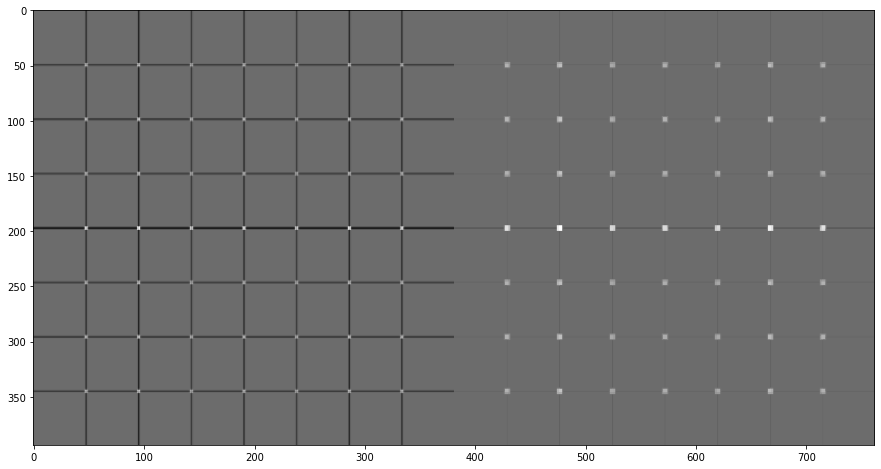

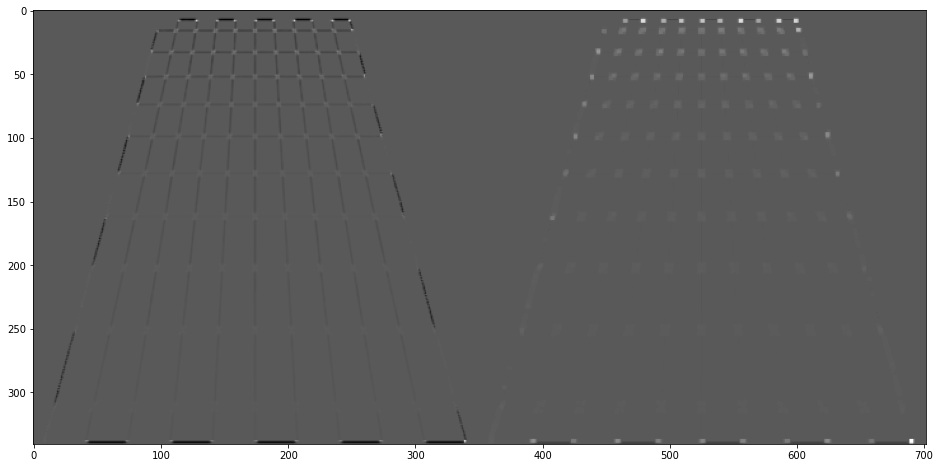

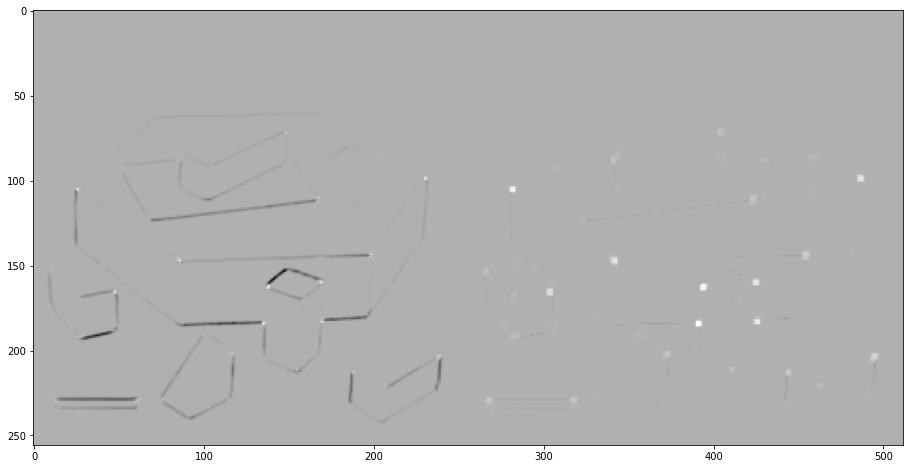

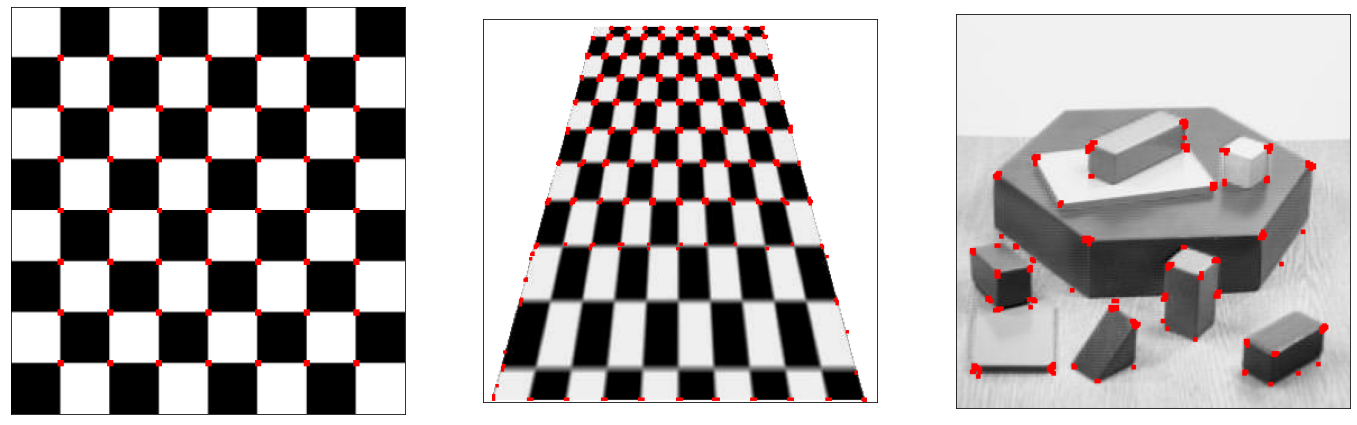

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

files = ['data/chessboard.png', 'data/chessboard-2.png', 'data/blox.jpg']
images = []

for i in range(3):
  img = cv.imread(files[i])
  gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
  gray = np.float32(gray)

  dst1 = cv.cornerHarris(gray,2,3,0.04)
  
  #result用于标记角点，并不重要
  dst2 = cv.dilate(dst1,None)

  res = np.hstack((dst1, dst2))
  plt.figure(figsize=(16,8))
  plt.imshow(res, 'gray')
  plt.show()

  img[dst2>0.01*dst2.max()]=[255,0,0]
  images.append(img)

plt.figure(figsize=(24,8))

for i in range(3):
  plt.subplot(1,3,i+1),plt.imshow(images[i])
  plt.xticks([]), plt.yticks([])

plt.show()

### SubPixel精度的转角 

有时，你可能需要找到最精确的角落。OpenCV附带了一个函数**cv.cornerSubPix**()，它进一步细化了以亚像素精度检测到的角落。下面是一个例子。和往常一样，我们需要先找到哈里斯角。然后我们通过这些角的质心(可能在一个角上有一堆像素，我们取它们的质心)来细化它们。Harris角用红色像素标记，精制角用绿色像素标记。对于这个函数，我们必须定义何时停止迭代的条件。我们在特定的迭代次数或达到一定的精度后停止它，无论先发生什么。我们还需要定义它将搜索角落的邻居的大小。

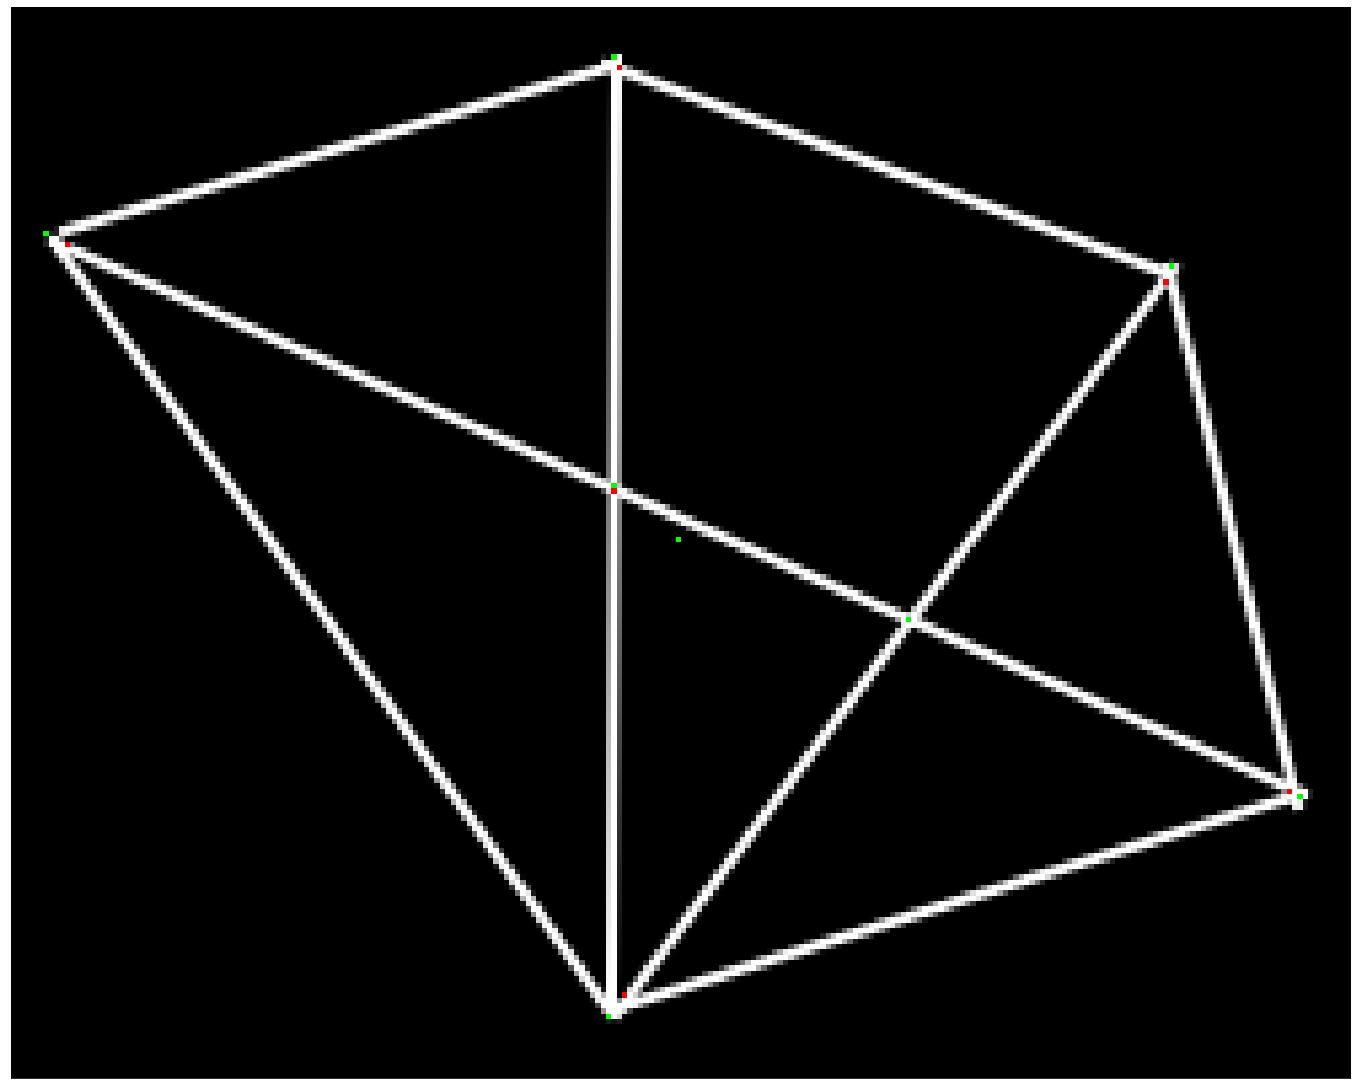

In [2]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

filename = 'data/chessboard2.png'
img = cv.imread(filename)
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

# 寻找哈里斯角
gray = np.float32(gray)
dst = cv.cornerHarris(gray,2,3,0.04)
dst = cv.dilate(dst,None)
ret, dst = cv.threshold(dst,0.01*dst.max(),255,0)
dst = np.uint8(dst)

# 寻找质心
ret, labels, stats, centroids = cv.connectedComponentsWithStats(dst)

# 定义停止和完善拐角的条件
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)

# 绘制
res = np.hstack((centroids,corners))
res = np.intp(res)
img[res[:,1],res[:,0]]=[255,0,0]
img[res[:,3],res[:,2]] = [0,255,0]

cv.imwrite('output/subpixel5.png',img)

plt.figure(figsize=(24,20))

plt.imshow(img)
plt.xticks([]), plt.yticks([])

plt.show()

### 附加资源

### 练习